# Import from Database and Analysis
This notebook imports shared Craigslist listings from the database on Istanbul for initial data exploration and analysis.

In [1]:
#import packages
import pandas as pd
import numpy as np
import re as re
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint  # library for making Python data structures readable
import psycopg2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import plotly as py
from plotly.graph_objs import *
pp = pprint.PrettyPrinter()
pd.options.mode.chained_assignment = None #disables warnings for editing copy of a dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x) #describe() vars are not in scientific notation
pd.set_option('max_columns', 30)
%matplotlib inline

In [2]:
# Defining font styles for graphics
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [3]:
# Creating function for defining colors for graphics
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [4]:
# Read in credentials from private settings file
with open('settings.json') as settings_file:    
    settings = json.load(settings_file)

In [5]:
#try to connect to database on local machine
dbname = settings['dbname']
user = settings['user']
host = settings['host']
password = settings['password']

conn_str = "dbname = {0} user = {1} host = {2} password = {3}".format(dbname, user, host, password)

try:
    conn = psycopg2.connect(conn_str)
except:
    print ("I am unable to connect to the database")

In [ ]:
# example dataframe with all the listings (as of 04/24, about 23k listings)
df = pd.read_sql_query("select * from shared_listings;",con=conn)


In [ ]:
df.shape

### April Listings

In [6]:
df_april = pd.read_sql_query("select * from shared_listings where dt < '2017-05-01' AND dt >= '2017-04-01';",con=conn)
df_april2 = pd.read_sql_query("select * from csv_sharedlistings where dt < '2017-05-01' AND dt >= '2017-04-01';",con=conn)

In [7]:
df_april2.rename(columns={'price': 'rent'}, inplace=True)

In [8]:
columns = ['pid', 'dt', 'url','title', 'rent', 'neighb', 'sqft', 'lat', 'lng','accuracy', 'body_text', 'furnished', 'laundry_known',
'laundry_onpremises', 'laundry_inunit', 'room_known', 'private_room', 'bath_known', 'parking_known', 'onsite_parking']
df_april = df_april[columns]
df_april2 = df_april2[columns]

In [9]:
df_april = df_april.reset_index()
df_april2 = df_april2.reset_index()

In [10]:
df = pd.concat([df_april, df_april2], axis=0)

In [81]:
df = df.reset_index()

In [82]:
df.shape

(798264, 29)

In [12]:
#df = df_april.append(df_april2)

In [83]:
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')
df['region'] = df['url'].str.extract('http://(.*).craigslist.org', expand=False)
df['day_of_week'] = df['dt'].apply(lambda x: x.weekday())

In [ ]:
df.dtypes

### Example SQL pulls

In [ ]:
# example syntax for pulling just those from newyork domain
df_nyc = pd.read_sql_query("select * from shared_listings where region = 'newyork';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25' AND dt < '2017-04-23';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25';",con=conn)

In [ ]:
df_april24 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-24'AND dt < '2017-04-25';",con=conn)

In [ ]:
df_april23 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-23'AND dt < '2017-04-24';",con=conn)

In [ ]:
#close database connection (no longer needed)
conn.close()

### De-Duplication

In [84]:
df.loc[df.lat == 99, 'lat'] = 0
df.loc[df.lng == 99, 'lng'] = 0
df.loc[df.sqft == 0, 'sqft'] = np.nan

#For any duplicate post, we want to keep the version with the most information. Therefore, assign a score to each post and 
#give one point for square footage, lat, long and price

df['price_exists'] = df['rent']>0
df['sqft_exists'] = df['sqft']>0
df['lat_exists'] = df['lat']>0
df['lng_exists'] = df['lng']<0
df['score'] = df[['price_exists','sqft_exists','lat_exists','lng_exists']].astype(bool).sum(axis=1)

In [85]:
#Sort rows by score
df = df.sort_values(by='score',ascending=False)

In [86]:
dedupe1 = pd.DataFrame(df.drop_duplicates(subset='pid', inplace=False))

In [87]:
print('first round of deduplication:', dedupe1.shape)

first round of deduplication: (309162, 29)


In [88]:
dedupe2 = pd.DataFrame(dedupe1.drop_duplicates(subset='body_text', inplace=False))

In [89]:
dedupe2.shape

(218389, 29)

### Quick bar chart to see impact of deduplication on sample size

In [ ]:
y = [len(df),len(dedupe1), len(dedupe2)]
labels = ['original', 'dedupe_pid', 'dedupe_body']
x = [1,2,3]

In [ ]:
plt.figure(figsize=(10,6) )
plt.suptitle('Deduplication Sample Size')
plt.xlabel('Deduplication Phase')
plt.ylabel('Number of Listings')
plt.xticks(x, labels)
ax = plt.bar(x, y, alpha=.4, color='cyan', align='center')
plt.show()

#### Code for plotting same histo w/Plotly

In [ ]:
#For initializing offline mode. Not working though...
#py.offline.init_notebook_mode() 

In [ ]:
data = [Bar(x=['original','dedupe_pid','dedupe_body'], y=[len(df),len(dedupe1), len(dedupe2)])]
py.offline.plot(data)

### More Filtering

In [90]:
# Filtering out listings that don't include rent price
unique_wprice = dedupe2[dedupe2['rent'] > 0]

In [91]:
unique_wprice.shape

(184009, 29)

In [92]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.997
lower_percentile = 0.07

# how many rows would be within the upper and lower percentiles?
upper = int(len(unique_wprice) * upper_percentile)
lower = int(len(unique_wprice) * lower_percentile)

# get the rent values at the upper and lower percentiles
rent_sorted = unique_wprice['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

print('valid rent range:', [lower_rent, upper_rent])

valid rent range: [300.0, 5495.0]


In [93]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (unique_wprice['rent'] > lower_rent) & (unique_wprice['rent'] < upper_rent)

In [94]:
filtered_listings = pd.DataFrame(unique_wprice[rent_mask])

In [95]:
filtered_listings.shape

(169189, 29)

In [96]:
#Creating dataframe that only includes shared listings that are private rooms
filtered_private_only = filtered_listings[filtered_listings['private_room']==True]

filtered_private_only.shape

(163011, 29)

### Full Filtered Database Charts

In [27]:
listings_ratios = pd.DataFrame()

#Number of total shared listings for reach region before deduplication or filtering
listings_ratios['all_shared_listings'] = df['region'].value_counts()

listings_ratios['deduplicated_pid'] = dedupe1['region'].value_counts()

listings_ratios['deduplicated_text'] = dedupe2['region'].value_counts()

listings_ratios['duplicate_listings'] = listings_ratios['all_shared_listings'] - listings_ratios['deduplicated_text'] 

listings_ratios['duplicate_ratio'] = listings_ratios['duplicate_listings']/listings_ratios['all_shared_listings']

listings_ratios['unique_ratio'] = listings_ratios['deduplicated_text']/listings_ratios['all_shared_listings']

In [ ]:
listings_ratios.head()

In [ ]:
# plot the ratios of unique and duplicate listings, by region. This is before dropping observations without lat-lngs!

countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_text','duplicate_listings']].head(20)
countdata.columns = ['Unique Listings', 'Duplicate Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[10, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and Duplicate Shared Rental Listings, by Region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()

## Spatial Join for Census Tracts

In [33]:
import geopandas as gpd

from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopy.distance import great_circle

from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 10, 8
import fiona

### California Regions

In [35]:
california = gpd.read_file("C:\\Users\\james\\Documents\\Berkeley_Docs\\Fall_16_Courses\\CP255\\Oct31_Geopandas_and_spatial_analysis\\spatial_analysis\\cb_2015_06_tract_500k\\cb_2015_06_tract_500k.shp")
print(type(california))
print(california.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4269'}


In [36]:
#Use California CRS
# California.crs = {'init' :'epsg:2227'}
#http://spatialreference.org/ref/epsg/2227/
california_crs = {'init': 'epsg:2227'}
california = california.to_crs(california_crs)
print(california.crs)

{'init': 'epsg:2227'}


In [97]:
sfbay = filtered_private_only[filtered_private_only['region']=='sfbay']

In [98]:
sfbay = sfbay[sfbay.lat != 0]

In [99]:
los_angeles = filtered_private_only[filtered_private_only['region']=='losangeles']

In [100]:
los_angeles = los_angeles[los_angeles.lat != 0]

### LA GeoDF

In [101]:
geometryMapping_la = [Point(xy) for xy in zip(los_angeles.lng, los_angeles.lat)]
geo_la = GeoDataFrame(los_angeles, crs={'init' :'epsg:4326'}, geometry=geometryMapping_la)
geo_la=geo_la.to_crs(california_crs)
print(type(geo_la))
print(geo_la.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


### SF GeoDF

In [102]:
geometryMapping = [Point(xy) for xy in zip(sfbay.lng, sfbay.lat)]
geo_sf = GeoDataFrame(sfbay, crs={'init' :'epsg:4326'}, geometry=geometryMapping)
geo_sf=geo_sf.to_crs(california_crs)
print(type(geo_sf))
print(geo_sf.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


In [43]:
geo_la.dtypes

index                          int64
pid                           object
dt                    datetime64[ns]
url                           object
title                         object
rent                         float64
neighb                        object
sqft                         float64
lat                          float64
lng                          float64
accuracy                       int64
body_text                     object
furnished                       bool
laundry_known                   bool
laundry_onpremises              bool
laundry_inunit                  bool
room_known                      bool
private_room                    bool
bath_known                      bool
parking_known                   bool
onsite_parking                  bool
region                        object
day_of_week                    int64
price_exists                    bool
sqft_exists                     bool
lat_exists                      bool
lng_exists                      bool
s

In [103]:
la_joined = gpd.sjoin(geo_la, california, how="inner", op='intersects')

In [104]:
sf_joined = gpd.sjoin(geo_sf, california, how="inner", op='intersects')

In [105]:
# Dropping unnecessary fields that came from Census shapefile
la_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)
sf_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)

### Mapping SF and LA Listings

In [ ]:
base = california.plot(color='gray', linewidth=.1)
sf_joined.plot(color='red', ax=base)
la_joined.plot(color='b', ax=base)
plt.show()

### Comparing Vacant to Shared Listings

In [48]:
vacant = pd.read_csv('april_listings2.csv',dtype={'fips_block':str})

In [49]:
# Creating a GEOID field that's comparable to shared listings
vacant['GEOID'] = vacant['fips_block'].str[:-4]

In [50]:
# Turning studios into 1BRs for calculating rent per bedroom
vacant['beds2'] = vacant['beds']
vacant.loc[vacant.beds2 == 0, 'beds2'] = 1


In [51]:
vacant['rent_per_br'] = vacant['rent']/vacant['beds2']

In [52]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.995
lower_percentile = 0.005

# how many rows would be within the upper and lower percentiles?
upper = int(len(vacant) * upper_percentile)
lower = int(len(vacant) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = vacant['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = vacant['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = vacant['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.26785714285700002, 5.8333333333300006]
valid rent range: [325.0, 6200.0]
valid sqft range: [300.0, 3222.0]


In [53]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (vacant['rent'] > lower_rent) & (vacant['rent'] < upper_rent)

In [54]:
filtered_vacant = pd.DataFrame(vacant[rent_mask])

In [55]:
# Snapshot of median prices for total sample
print('median rent for all vacant listings:', filtered_vacant['rent'].median())
print('median rent for all vacant Studio Units:',(filtered_vacant[filtered_vacant['beds']==0])['rent_per_br'].median())
print('median rent for all vacant 1BR Units:',(filtered_vacant[filtered_vacant['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all vacant listings:', filtered_vacant['rent_per_br'].median())
print('median rent per bedroom for all multi-bedroom vacant listings:', (filtered_vacant[filtered_vacant['beds'] > 1])['rent_per_br'].median())

median rent for all vacant listings: 1235.0
median rent for all vacant Studio Units: 1263.0
median rent for all vacant 1BR Units: 1103.0
median rent per bedroom for all vacant listings: 762.0
median rent per bedroom for all multi-bedroom vacant listings: 565.0


In [56]:
vacant_sfbay = vacant[vacant['region']=='sfbay']

In [106]:
vacant_sfbay.shape

(57269, 17)

In [107]:
# Note: If we apply a filter for individual regions, we'd probably want to adjust the parameters to account for the smaller 
# sample size and different market; for example, $5000 is not a super atypical price in the Bay Area, shouldn't be filtered out 
print('median rent for all SF vacant listings:', vacant_sfbay['rent'].median())
print('median rent for all SF vacant Studio Units:',(vacant_sfbay[vacant_sfbay['beds']==0])['rent_per_br'].median())
print('median rent for all SF vacant 1BR Units:',(vacant_sfbay[vacant_sfbay['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all SF vacant listings:', vacant_sfbay['rent_per_br'].median())
print('median rent per bedroom for all SF multi-bedroom vacant listings:', (vacant_sfbay[vacant_sfbay['beds'] > 1])['rent_per_br'].median())

median rent for all SF vacant listings: 2699.0
median rent for all SF vacant Studio Units: 2198.0
median rent for all SF vacant 1BR Units: 2345.0
median rent per bedroom for all SF vacant listings: 1764.0
median rent per bedroom for all SF multi-bedroom vacant listings: 1375.0


In [59]:
(vacant_sfbay[vacant_sfbay['beds'] > 1]).shape

(32010, 17)

In [60]:
print('median rent for room in SF shared listing:', sf_joined['rent'].median())

median rent for room in SF shared listing: 1100.0


In [ ]:
vacant_la = vacant[vacant['region']=='losangeles']

In [ ]:
#vacant2 = vacant[(vacant['GEOID'] != '')]

### SF Comparison

In [61]:
# Grouping and aggragating by GEOID for vacant SF listings
sf_vacant_grouped = vacant_sfbay.groupby(by='GEOID')
sf_vacant_grouped = sf_vacant_grouped.agg({'rent_per_br':['mean','median','count']}).reset_index()

In [62]:
#Now, need to turn newly created multi-index dataframe into a single index dataframe 
sf_vacant_grouped.columns = sf_vacant_grouped.columns.get_level_values(1)
sf_vacant_grouped.columns = ['GEOID','vacant_tract_mean','vacant_tract_median','vacant_tract_count']

In [64]:
sf_vacant_grouped.sort_values(by='vacant_tract_count', ascending=False).head()

,GEOID,vacant_tract_mean,vacant_tract_median,vacant_tract_count
856,06075061500,3347.896,3260.500,836
851,06075060700,3081.371,2900.000,639
1193,06085505009,1973.057,1684.000,552
1189,06085505001,2018.453,2050.000,438
1192,06085505008,2133.390,2350.000,432


In [65]:
sf_shared_grouped = sf_joined.groupby(by='GEOID')
sf_shared_grouped = sf_shared_grouped.agg({'rent':['mean','median','count']}).reset_index()

In [66]:
#Now, need to turn newly created multi-index 
sf_shared_grouped.columns = sf_shared_grouped.columns.get_level_values(1)

In [67]:
sf_shared_grouped.columns = ['GEOID','shared_tract_mean','shared_tract_median','shared_tract_count']

In [68]:
sf_shared_grouped.sort_values(by='shared_tract_count', ascending=False).head()

,GEOID,shared_tract_mean,shared_tract_median,shared_tract_count
662,06075022901,1119.675,1100.000,151
634,06075017802,1499.633,1330.000,139
756,06075061500,1751.000,1572.000,134
1169,06085509201,1222.408,1180.000,120
623,06075016600,1345.203,1318.500,118


In [69]:
# Merging shared and vacant listings on GEOID
sf_compare=pd.merge(sf_shared_grouped,sf_vacant_grouped,how='outer',on='GEOID')

In [70]:
sf_compare.head()

,GEOID,shared_tract_mean,shared_tract_median,shared_tract_count,vacant_tract_mean,vacant_tract_median,vacant_tract_count
0,06001400100,1250.000,1250.000,1.000,1572.429,1633.333,14.000
1,06001400200,1590.000,1590.000,1.000,2073.750,2047.500,4.000
2,06001400300,1119.714,1100.000,7.000,2389.107,2125.000,70.000
3,06001400400,1344.059,1335.000,17.000,1882.754,1800.000,23.000
4,06001400500,875.385,900.000,13.000,1777.679,1875.000,14.000


In [72]:
sf_compare.sort_values(by='shared_tract_count', ascending=False).head()

,GEOID,shared_tract_mean,shared_tract_median,shared_tract_count,vacant_tract_mean,vacant_tract_median,vacant_tract_count
662,06075022901,1119.675,1100.000,151.000,2490.571,2631.667,46.000
634,06075017802,1499.633,1330.000,139.000,2707.898,2625.000,301.000
756,06075061500,1751.000,1572.000,134.000,3347.896,3260.500,836.000
1169,06085509201,1222.408,1180.000,120.000,2210.224,2200.000,171.000
623,06075016600,1345.203,1318.500,118.000,2359.228,2083.333,52.000


In [73]:
# Converting NaNs to 0s
#sf_compare = sf_compare.fillna(0)

In [74]:
# Creating column that calculates difference between tract medians for vacant and shared listings
sf_compare['difference'] = sf_compare['vacant_tract_median'] - sf_compare['shared_tract_median']
sf_compare['gap_ratio'] = sf_compare['shared_tract_median']/sf_compare['vacant_tract_median']

In [75]:
# Sorting by tracts with most shared listings
sf_compare.sort_values(by='shared_tract_count', ascending=False).head()

,GEOID,shared_tract_mean,shared_tract_median,shared_tract_count,vacant_tract_mean,vacant_tract_median,vacant_tract_count,difference,gap_ratio
662,06075022901,1119.675,1100.000,151.000,2490.571,2631.667,46.000,1531.667,0.418
634,06075017802,1499.633,1330.000,139.000,2707.898,2625.000,301.000,1295.000,0.507
756,06075061500,1751.000,1572.000,134.000,3347.896,3260.500,836.000,1688.500,0.482
1169,06085509201,1222.408,1180.000,120.000,2210.224,2200.000,171.000,1020.000,0.536
623,06075016600,1345.203,1318.500,118.000,2359.228,2083.333,52.000,764.833,0.633


In [ ]:
# Necessary to keep lead '0' in GEOID column when exported to .csv. Only for ArcMap
# sf_compare.GEOID = sf_compare.GEOID.apply('="{}"'.format)

In [76]:
sf_compare.to_csv('sf_compare.csv')

### LA Comparison

In [ ]:
la_vacant_grouped = vacant_la.groupby(by='GEOID')
la_vacant_grouped = la_vacant_grouped.agg({'rent_per_br':['mean','median','count']}).reset_index()

In [ ]:
#Now, need to turn newly created multi-index dataframe into a single index dataframe 
la_vacant_grouped.columns = la_vacant_grouped.columns.get_level_values(1)
la_vacant_grouped.columns = ['GEOID','vacant_tract_mean','vacant_tract_median','vacant_tract_count']
la_vacant_grouped.sort_values(by='vacant_tract_count', ascending=False).head()

In [ ]:
la_shared_grouped = la_joined.groupby(by='GEOID')
la_shared_grouped = la_shared_grouped.agg({'rent':['mean','median','count']}).reset_index()

In [ ]:
#Now, need to turn newly created multi-index 
la_shared_grouped.columns = la_shared_grouped.columns.get_level_values(1)
la_shared_grouped.columns = ['GEOID','shared_tract_mean','shared_tract_median','shared_tract_count']

In [ ]:
la_compare=pd.merge(la_shared_grouped,la_vacant_grouped,how='outer',on='GEOID')

In [ ]:
la_compare['difference'] = la_compare['vacant_tract_median'] - la_compare['shared_tract_median']
la_compare['gap_ratio'] = la_compare['shared_tract_median']/la_compare['vacant_tract_median']

In [ ]:
la_compare.sort_values(by='shared_tract_count', ascending=False).head()

## New York Comparison

### Loading NY Shapefile and Performing Spatial Join 

In [108]:
newyork = gpd.read_file('C:\\Users\\james\\Documents\\Berkeley_Docs\\Spring_17_Courses\\CP290 Data Lab\\Database\\ny_census_shapefile\\cb_2016_36_tract_500k.shp')
print(type(newyork))
print('original crs:',newyork.crs)
#Use New York NAD83 Central CRS
# California.crs = {'init' :'epsg:2227'}
#http://spatialreference.org/ref/epsg/2227/
newyork_crs = {'init': 'epsg:2261'}
newyork = newyork.to_crs(newyork_crs)
print('updated crs:',newyork.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
original crs: {'init': 'epsg:4269'}
updated crs: {'init': 'epsg:2261'}


In [109]:
# Create dataframe for NYC listings including only private rooms with lat-lng info
new_york = filtered_private_only[filtered_private_only['region']=='newyork']
new_york = new_york[new_york.lat != 0]

In [110]:
geometryMapping_ny = [Point(xy) for xy in zip(new_york.lng, new_york.lat)]
geo_ny = GeoDataFrame(new_york, crs={'init' :'epsg:4269'}, geometry=geometryMapping_ny)
geo_ny=geo_ny.to_crs(newyork_crs)
print(type(geo_ny))
print(geo_ny.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2261'}


In [111]:
ny_joined = gpd.sjoin(geo_ny, newyork, how='inner', op='intersects')

In [112]:
ny_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)

### Conducting Comparison Between Vacant and Shared NYC Listings

In [113]:
vacant_newyork = vacant[vacant['region']=='newyork']

In [114]:
# Grouping and aggragating by GEOID for vacant SF listings
ny_vacant_grouped = vacant_newyork.groupby(by='GEOID')
ny_vacant_grouped = ny_vacant_grouped.agg({'rent_per_br':['mean','median','count']}).reset_index()

In [115]:
#Now, need to turn newly created multi-index dataframe into a single index dataframe 
ny_vacant_grouped.columns = ny_vacant_grouped.columns.get_level_values(1)
ny_vacant_grouped.columns = ['GEOID','vacant_tract_mean','vacant_tract_median','vacant_tract_count']

In [116]:
ny_shared_grouped = ny_joined.groupby(by='GEOID')
ny_shared_grouped = ny_shared_grouped.agg({'rent':['mean','median','count']}).reset_index()

In [117]:
#Now, need to turn newly created multi-index into single index dataframe
ny_shared_grouped.columns = ny_shared_grouped.columns.get_level_values(1)
ny_shared_grouped.columns = ['GEOID','shared_tract_mean','shared_tract_median','shared_tract_count']

In [118]:
ny_compare=pd.merge(ny_shared_grouped,ny_vacant_grouped,how='outer',on='GEOID')
ny_compare['difference'] = ny_compare['vacant_tract_median'] - ny_compare['shared_tract_median']
ny_compare['gap_ratio'] = ny_compare['shared_tract_median']/ny_compare['vacant_tract_median']
ny_compare.sort_values(by='shared_tract_count', ascending=False).head()

,GEOID,shared_tract_mean,shared_tract_median,shared_tract_count,vacant_tract_mean,vacant_tract_median,vacant_tract_count,difference,gap_ratio
1028,36081025100,700.506,650.000,237.000,1441.667,1300.000,7.000,650.000,0.500
363,36047038700,995.228,940.000,219.000,1296.077,1225.000,13.000,285.000,0.767
1047,36081028100,752.618,700.000,191.000,1723.529,1800.000,17.000,1100.000,0.389
390,36047043100,1103.690,975.000,168.000,1061.947,1033.333,10.000,58.333,0.944
1111,36081047500,817.906,750.000,149.000,1210.833,1237.500,10.000,487.500,0.606


### Conducting Comparison Between Vacant and Shared Chicago Listings

## Visualz

In [119]:
listings_ratios['all_vacant_listings'] = vacant['region'].value_counts()
listings_ratios['shared_to_vacant_ratio'] = listings_ratios['deduplicated_text']/listings_ratios['all_vacant_listings']

In [120]:
listings_ratios.head()

,all_shared_listings,deduplicated_pid,deduplicated_text,duplicate_listings,duplicate_ratio,unique_ratio,all_vacant_listings,shared_to_vacant_ratio
newyork,189865,49485,24164,165701,0.873,0.127,14211.000,1.700
sfbay,59265,26200,18961,40304,0.680,0.320,57269.000,0.331
washingtondc,44391,17031,11001,33390,0.752,0.248,73440.000,0.150
losangeles,44259,19337,12756,31503,0.712,0.288,57405.000,0.222
boston,24722,9865,6525,18197,0.736,0.264,10427.000,0.626


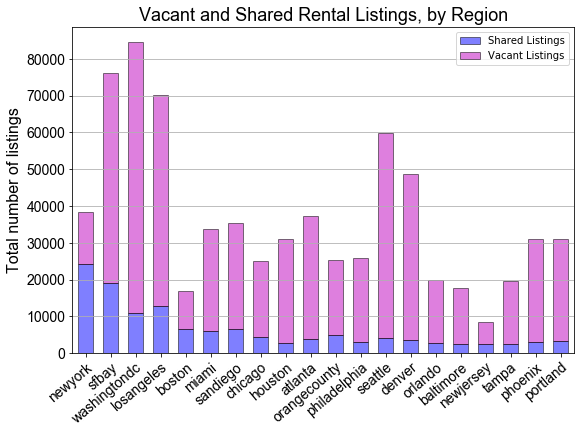

In [121]:
# plot the ratios of shared and vacant listings, by region
countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_text','all_vacant_listings']].head(20)
countdata.columns = ['Shared Listings', 'Vacant Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[9, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Vacant and Shared Rental Listings, by Region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()